## HOW TO:

* You have to write **CODE** directly inside specified places marked by comments: **BEGIN/END Solution**. Do not create new cells.

* In some problems you are asked to provide a short discussion of the results. For that find the specific place marked via **Your text answer: \<write your answer\>**.

* For every separate problem or subproblem (if specified) you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task.

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e., if the reviewer decides to restart the notebook and run all cells, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest fixing random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include necessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

## Task 1. Deep ANNs. (3 points)

-  **(1 pt.)** Activation functions; **(sub tasks 1.1)**
-  **(2 pt.)** MNIST classification.  **(sub tasks 1.2)**


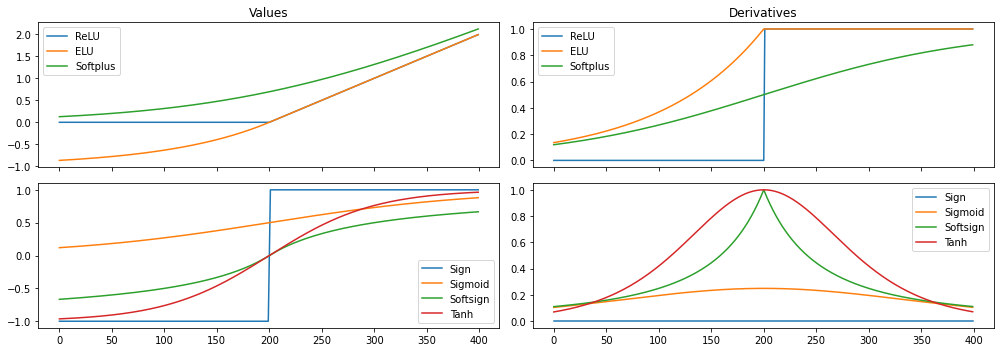

In [660]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

x = torch.arange(-2, 2, .01, requires_grad=True)
x_np = x.detach().numpy()
x.sum().backward() # to create x.grad

f, axes = plt.subplots(2, 2, sharex=True, figsize=(14, 5))
axes[0, 0].set_title('Values')
axes[0, 1].set_title('Derivatives')

names = []

for i, function_set in (0, (('ReLU', F.relu), ('ELU', F.elu), ('Softplus', F.softplus))), \
                       (1, (('Sign', torch.sign), ('Sigmoid', torch.sigmoid), ('Softsign', F.softsign), ('Tanh', torch.tanh))):
    for function_name, activation in function_set:
        ### BEGIN Solution

        names.append(function_name)
        f = activation(x)
        x.grad = torch.zeros_like(x)
        f.sum().backward()
        d = x.grad
        
        axes[i, 0].plot(f.data, label=function_name)
        axes[i,1].plot(d.data, label=function_name)

        ### END Solution

    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### Task 1.1.  Activation functions. 

Given different activation functions and their derevatives describe which are a good or a bad choice. Which of these functions may be, and which - definitely, are a poor choise as an activation function in a neural network? Why? Do not forget that output of the current layer sometimes servers as an input for the following one. Imagine a situation where we have many layers, what happens with the activation values? Write 2 - 3 senteces about each function.

### Your answer:


*   ReLU

ReLU is definitely one the best and popular choices, because it can be easly implemented (comparing to Sigmoid) in PCs. The fact that for the negative input result is zero leads to the computational efficiency of ReLU. Nevertheless, having zero derivative on x<0, we can see, that during the backpropogation process the weights for some neurons are not updated.
*   ELU

Exponential_LU is a varinat of ReLU, which has no problems with zero gradient.

*   Sign

Sign can be used for the binary classification task. But having zero gradient, the nn with this activation function will not update its weights.
*   Sigmoid

Having output values in range [0,1], sigmoid can be used as an exit function in binary classifiers, but it is a better choice comparing to Sign, because its gradient is non zero. Nevertheless,for values greater than 3 or less than -3 we will have very small gradients, and network will not really learn. Moreover, sigmoid is not symmetric around zero, so output of all neurons will be of the same sign.

*   Tanh

Tanh is very similar to the sigmoid, but ths range of its values is from -1 to 1. Thus, the inputs to the next layers will not always be of the same sign. Here we can also see the problem of the vanishing gradients.



### Task 1.2. MNIST classification. 

MLP (Multilayer perceptron) with one hidden layer, logistic activation functions and softmax. 

In this task, you are to:

1. Implement the MLP modules, including the Softmax cross entropy between `logits` and `labels` using numpy. Look at **BEGIN/END Solution** you will need to write some code there.

2.  Train your numpy realization of MLP to classify the MNIST from `sklearn.datasets()`. The required accuracy on validation is `> 90%`.

3. Print a confusion matrix and discuss results, 1 - 2 sentences.

In [661]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [662]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]
test_size = digits_test.shape[0]

input_size = 8*8
classes_n = 10

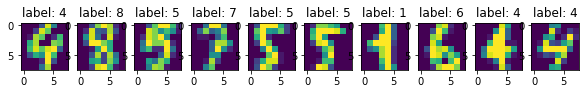

In [663]:
N = 10

sample_idx = np.random.choice(1797, N, replace=False)
digits_sample = digits[sample_idx]
targets_sample = targets[sample_idx]
f, ax  = plt.subplots(1,10, figsize=(10, 5))

for i in range(N):
    ax[i].imshow(digits_sample[i].reshape(8,8))
    ax[i].set_title('label: '+str(targets_sample[i]))


A short recap on what we are going to achieve here.
<br>
1. Forward pass:
$$
h_1 = X\theta_1+\beta_1
$$


$$
O_1 = sig(h_1) \space\space 
$$
$$
("sig" \, is \, sigmoid \, here)
$$

$$
h_2 = O_1\theta_2+\beta_2
$$
$$
O_2 = softmax(h_2)
$$
$$
Loss = CrossEntropy(O_2, true \space labels)
$$

2. Compute gradients: 

To update weights first we need to compute loss gradients with respect to $\theta_1$ and $\theta_2$ and then update both $\theta$ and $\beta$.

$$
\frac{ \partial{loss} }{\partial{\theta_2}} = \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}}\frac{ \partial{h_2} }{\partial{\theta_2}}
$$
Note, that $\frac{ \partial{h_2} }{\partial{\theta_2}}=O_1$, so we can cache this value during forward pass to speed up our computation.
$$
\frac{ \partial{loss} }{\partial{\theta_1}} = \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}}\frac{ \partial{h_2} }{\partial{O_1}}\frac{ \partial{O_1} }{\partial{h_1}}\frac{ \partial{h_1} }{\partial{\theta_1}}
$$
Note, that $\frac{ \partial{h_1} }{\partial{\theta_1}}=X$.

Since we are using sigmoid avtivation function here and
$$
\frac{ \partial{sig} }{\partial{h}} = sig(h)(1 - sig(h))
$$
It also makes sense to cache sig(h) during forward pass.
3. Update weights:

$\theta:= \theta -  \frac{ \partial{loss} }{\partial{\theta}}\alpha$, where $\alpha$ is some learning rate.

Note, it was not shown here how to update and compute $\beta$ but you can do it!

### Implement the MLP with backprop

In [664]:
### YOUR TASK STARTS HERE ###

#Here you should implement by yourself MLP class and its constituents including forward and backward propagation methods

class Linear:
    def __init__(self, input_size, output_size):
        # Trainable parameters of the layer and their gradients
        self.thetas = np.random.randn(input_size, output_size) # the weight matrix of the layer (W)
        self.thetas_grads = np.empty_like(self.thetas) # gradient w.r.t. the weight matrix of the layer
        self.bias = np.random.randn(output_size) # bias terms of the layer (b)
        self.bias_grads = np.empty_like(self.bias) # gradient w.r.t. bias terms of the linear layer

    def forward(self, x): 
        # keep x for backward computation
        self.x = x
        output = np.matmul(x, self.thetas) + self.bias
        return output
    
    def backward(self, output_grad, learning_rate):
        """
        Calculate and return gradient of the loss w.r.t. the input of linear layer given the input x and the gradient 
        w.r.t output of linear layer. You should also calculate and update gradients of layer parameters.
        :param x: np.array, input tensor for linear layer;
        :param output_grad: np.array, grad tensor w.r.t output of linear layer;
        :return: np.array, grad w.r.t input of linear layer
        """
        
        ### BEGIN Solution
        # ... calculate grads
        # >>> your solution here <<<
        input_grad =np.matmul(output_grad.reshape((1,-1)),self.thetas.transpose() )
        self.thetas_grads = self.x.transpose() * output_grad
        
        self.bias_grads = output_grad
      
        self.step(learning_rate)
        
        ### END Solution
        return input_grad

    def step(self, learning_rate):
        self.thetas -= self.thetas_grads * learning_rate
        squeezed_bias_grads = np.squeeze(self.bias_grads)
        self.bias -= squeezed_bias_grads * learning_rate

class LogisticActivation:
    def __init__(self):
        # the layer has no parameters
        pass 
        
    def sig(self, x):
        return 1/(1 + np.exp(-x))

    def forward(self, x):
        # keep o for backward computation
        self.o = self.sig(x)
        return self.o 


    def backward(self,  output_grad, learning_rate=None):
        """
        Calculate and return the gradient of the loss w.r.t. the input
        of logistic non-linearity (given input x and the gradient 
        w.r.t output of logistic non-linearity).
        
        :param x: np.array, input tensor for logistic non-linearity;
        :param output_grad: np.array, grad tensor w.r.t output of logistic non-linearity;
        :return: np.array, grad w.r.t input of logistic non-linearity
        
        """
        input_grad = (self.o) * (1-self.o) * output_grad
        
        return input_grad


class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        h1 = self.linear1.forward(x)
        h1a = self.activation1.forward(h1)
        out = self.linear2.forward(h1a)
        return out

    def backward(self, output_grad, learning_rate):
        """
        Calculate and return the gradient of the loss w.r.t. the input of MLP given the input and the gradient 
        w.r.t output of MLP. You should also update gradients of paramerters of MLP layers.
        Hint - you should chain backward operations of modules you have already implemented. You may also
        need to calculate intermediate forward results.
        
        :param x: np.array, input tensor for MLP;
        :param output_grad: np.array, grad tensor w.r.t output of MLP;
        :return: np.array, grad w.r.t input of MLP
        """


        g1 = self.linear2.backward(output_grad, learning_rate)
        g2 = self.activation1.backward(g1, learning_rate)
        out = self.linear1.backward(g2, learning_rate)
        
        return  out


In [665]:
### BEGIN Solution
def softmax_crossentropy_with_logits(logits, reference_answers):    
    # >>> your solution here <<<
    #we implement cross entroppy loss here, but before we pull logits through softmax #
    loss = reference_answers[0] * np.log((np.exp(logits[0][reference_answers[0]]))/(np.sum(np.exp(logits[0]))))
    ### END Solution
    return loss

# grad means gradiends 
def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    # >>> your solution here <<<
    # just implemented derivative of (softmax + CE loss) here
    n = classes_n
    grad = np.empty([n])
    target = reference_answers[0]
    for s in range(0,n):
        if s == target:
            sum =   ((np.exp(logits[0][s]))/(np.sum(np.exp(logits[0]))) - 1)
        else:
            sum =   ((np.exp(logits[0][s]))/(np.sum(np.exp(logits[0]))))
        grad[s] = sum
    return grad
### END Solution

In [666]:
np.random.seed(42)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 100
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-2

for epoch in range(epochs_n):
    
    y_pred = []

    for sample_i in range(train_size):
        x = x_train[sample_i].reshape((1, -1))
        target = np.array([y_train[sample_i]])
        logits = mlp.forward(x)
        
        
        loss = softmax_crossentropy_with_logits(logits, target)
        output_grad = grad_softmax_crossentropy_with_logits(logits, target)
        
        mlp.backward(output_grad, learning_rate) # step is in backward

        y_pred.extend(logits.argmax(1))

    if epoch % 10 == 0:
        
        y_pred_test = []

        for sample_i in range(test_size):
            x = x_test[sample_i].reshape((1, -1))
            target = np.array([y_test[sample_i]])
            
            logits = mlp.forward(x)
            y_pred_test.extend(logits.argmax(1))

        print('Starting epoch {}'.format(epoch), \
              ', Loss : {:.3}'.format(loss), \
              ', Accuracy on train: {:.3}'.format(accuracy_score(y_train, y_pred)), \
              ', Accuracy on test: {:.3}'.format(accuracy_score(y_test, y_pred_test)) )
        

Starting epoch 0 , Loss : -21.7 , Accuracy on train: 0.103 , Accuracy on test: 0.0667
Starting epoch 10 , Loss : -17.2 , Accuracy on train: 0.625 , Accuracy on test: 0.649
Starting epoch 20 , Loss : -12.4 , Accuracy on train: 0.821 , Accuracy on test: 0.807
Starting epoch 30 , Loss : -8.55 , Accuracy on train: 0.875 , Accuracy on test: 0.871
Starting epoch 40 , Loss : -5.94 , Accuracy on train: 0.9 , Accuracy on test: 0.889
Starting epoch 50 , Loss : -4.27 , Accuracy on train: 0.911 , Accuracy on test: 0.904
Starting epoch 60 , Loss : -3.19 , Accuracy on train: 0.92 , Accuracy on test: 0.924
Starting epoch 70 , Loss : -2.47 , Accuracy on train: 0.927 , Accuracy on test: 0.931
Starting epoch 80 , Loss : -1.96 , Accuracy on train: 0.929 , Accuracy on test: 0.931
Starting epoch 90 , Loss : -1.59 , Accuracy on train: 0.936 , Accuracy on test: 0.933


In [667]:
confusion_matrix(y_test, y_pred_test)

array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 39,  0,  0,  0,  0,  2,  0,  0,  2],
       [ 0,  2, 40,  1,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 42,  0,  0,  0,  1,  1,  1],
       [ 0,  0,  0,  0, 37,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  0,  0,  0,  2],
       [ 0,  1,  0,  0,  0,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 48,  0,  0],
       [ 0,  4,  1,  0,  0,  1,  0,  1, 41,  0],
       [ 0,  0,  0,  4,  0,  2,  0,  1,  1, 39]])

### Discuss results based on confusion matrix, your answer here. 
<br>
Describe your observations, how can we see that our NN does not overfit?
<br>
MY ANSWER:


<br>
- first of all, if we look at the accuracies on train and on test, we will see that the difference between them is relatively small, which is a good sign

<br>
- secondly, from the confusion matrix we infer that the for each class predicted value and actual value are often coinside, which tells us that the net works fine on test


## Task 2. Autoencoders on tabular data (2 points)
**From now on we will be using pytorch for all the tasks.**

We will build a latent representation for tabular data with simple Autoencoder (AE). We are going to work with the cancer dataset from scikit-learn package. You are to follow the instructions.  

1. **(1 pt.)**  Implement AE modules for tabular data. Train AE to get latent representation of the cancer dataset from `sklearn.datasets()`. Use `MSE` loss and get < $0.3$ on validation, with AE "bottleneck" = $2$;   **(sub tasks 2.1 - 2.4)**

2. **(1 pt.)** Plot the latent representation of whole dataset in 2D, use colors to show object of differneet classes. **(sub tasks: 2.5)**. Write 1 - 2 sentences to explain your results.

In [668]:
# imports

import torch
import torch.nn as nn
import torch.utils.data as torch_data

import sklearn.datasets as sk_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


#### 1.1 Fetch the data. Scale it and split on train and test.

In [678]:


cancer_dset = sk_data.load_breast_cancer()

X_train, X_val, y_train, y_val = train_test_split(cancer_dset['data'], cancer_dset['target'], test_size=0.2, random_state=42)
print('\nTrain size: ', len(X_train))
print('Validation size: ', len(X_val))

scaler = StandardScaler() 
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

print('Features: ', list(cancer_dset['feature_names']), len(cancer_dset['feature_names']))
print('\nShape:', X_train.shape)




Train size:  455
Validation size:  114
Features:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension'] 30

Shape: (455, 30)


#### 2.2 Let us firstly create the dataset, which we'll be able to use with pytorch dataloader. 
Implement `__len__` and `__getitem__` methods.

In [679]:
class CancerData(torch_data.Dataset):
    def __init__(self, X, y):
        super(CancerData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [680]:
train_dset = CancerData(X_train, y_train) 
val_dset = CancerData(X_val, y_val) 


#### 2.3 Now, we'll make a base class for our autoencoder. 
AE takes as input encoder and decoder (it will be two neural networks). Your task is to implement the forward pass.

In [681]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### It is high time to create encoder an decoder neural networks!
Make hidden size of the network to be equal to `2`.

**Hint.** You can use `nn.Sequential` to create your own archtectures.

In [764]:
# SOLUTION

class encoder(torch.nn.Module):
    def __init__(self, dim):
        super(encoder, self).__init__()
        self.dim = dim
        self.enc = nn.Sequential(
        # YOUR CODE HERE
            nn.Linear(30,dim),
            nn.BatchNorm1d(dim),
            nn.Linear(dim,dim)
        )  
    
    
    def forward(self, x):
        return self.enc(x)
    
class decoder(torch.nn.Module):
    def __init__(self, dim):
        super(decoder, self).__init__()
        self.dim = dim
        self.dec = nn.Sequential(
        # YOUR CODE HERE
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.Linear(dim, 30),
             nn.BatchNorm1d(30),
           
            
            
           
            
        )  
        
    def forward(self, x):
        return self.dec(x)

In [773]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = MyFirstAE(encoder(2), decoder(2)) 






criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(10,20, 50), gamma=1/2)


train_loader = torch_data.DataLoader(train_dset, batch_size=100, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size= 100, shuffle=False) 


#### 2.4 Implement the missing parts of the `train` function

In [774]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    
    freq = max(epochs//20,1)
    net.to(device)
    
    for epoch in range(1, epochs+1):
        net.train()

        losses_train = []
        for X, _ in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            # >>> your solution here <<<
            X = X.to(device)
            out = net(X)
            loss = criterion(X,out)
            # >>> SOLUTION ENDS HERE
            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_train.append(loss.item())

        
        net.eval()
        for X, _ in val_loader:
            losses_val = []
            X = X.to(device)
            out = net(X)
            loss_val = criterion(X, out)
            losses_val.append(loss_val.item())

        if scheduler is not None:
            scheduler.step()
        
        if verbose and epoch%freq==0:
            mean_val = sum(losses_val)/len(losses_val)
            mean_train = sum(losses_train)/len(losses_train)

            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'\
                  .format(epoch, epochs, mean_train, mean_val))


#### 2.5 Train your AE on breast cancer dataset. 
Your goal is to get validation error <0.3.

Some features that may help you to improve the performance:
* `Dropout`
* `Batchnorm`
* lr scheduler
* Batch size increase/decrease

In [775]:
# for `MSE` loss get < 0.3 on validation, with AE "bottleneck" = 2
train(5000, net, criterion, optimizer, train_loader, val_loader, scheduler) 


Epoch 250/5000 || Loss:  Train 0.5650 | Validation 0.5434
Epoch 500/5000 || Loss:  Train 0.5122 | Validation 0.4609
Epoch 750/5000 || Loss:  Train 0.4524 | Validation 0.4151
Epoch 1000/5000 || Loss:  Train 0.4359 | Validation 0.3820
Epoch 1250/5000 || Loss:  Train 0.4118 | Validation 0.3540
Epoch 1500/5000 || Loss:  Train 0.3971 | Validation 0.3277
Epoch 1750/5000 || Loss:  Train 0.3956 | Validation 0.3186
Epoch 2000/5000 || Loss:  Train 0.3923 | Validation 0.3152
Epoch 2250/5000 || Loss:  Train 0.3920 | Validation 0.3138
Epoch 2500/5000 || Loss:  Train 0.3919 | Validation 0.3132
Epoch 2750/5000 || Loss:  Train 0.3855 | Validation 0.3127
Epoch 3000/5000 || Loss:  Train 0.3788 | Validation 0.3128
Epoch 3250/5000 || Loss:  Train 0.3943 | Validation 0.3135
Epoch 3500/5000 || Loss:  Train 0.4020 | Validation 0.3137
Epoch 3750/5000 || Loss:  Train 0.3781 | Validation 0.3125
Epoch 4000/5000 || Loss:  Train 0.3894 | Validation 0.3132
Epoch 4250/5000 || Loss:  Train 0.3795 | Validation 0.3133


#### 2.6 Let us take a look at the latent space. 
Encode the whole dataset, using your AE, plot it in 2D and use colors to indicate objects of differrent classes

<ipython-input-776-865080b28057>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc = net.encoder(torch.tensor(X, dtype=torch.float32))# >>> your solution here <<<


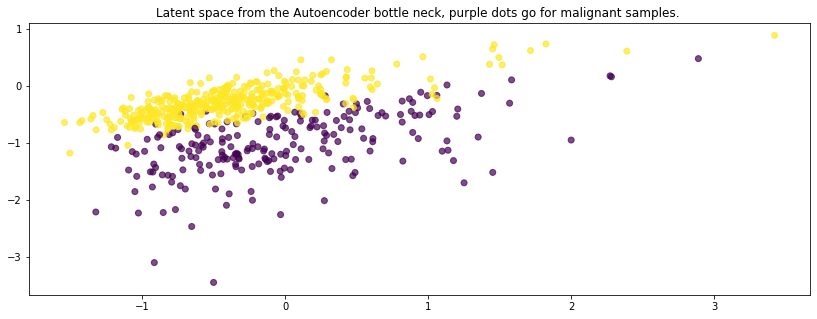

In [776]:
 ### BEGIN Solution


scaler.fit(cancer_dset['data'])
data_set = scaler.transform(cancer_dset['data'])
loader = torch_data.DataLoader(data_set, shuffle=False)


ar = np.array([[0,0]])


plt.figure(figsize=(14, 5))
net.eval()
for X in loader:
    
    enc = net.encoder(torch.tensor(X, dtype=torch.float32))# >>> your solution here <<<
    #enc = net.encoder(X.clone().detach())
    enc = enc.data.cpu().numpy()
    ar = np.concatenate((ar,enc), axis=0)
    

ar = np.delete(ar, 0,0)
plt.scatter(ar[:,0], ar[:,1], c=cancer_dset['target'] , alpha=0.7);
    
plt.title('Latent space from the Autoencoder bottle neck, purple dots go for malignant samples. ');

 ### END Solution

### Discuss results based on resutling plot. 
<br>
Describe your observations, answer how can we be sure we have a good latent represntaion, what is a good latent represntaion?
<br>
MY ANSWER:
<br>
We can see a 2-dimensional representation of the initial data.
Here latent space is a space of encoded data, malignant samples group toghether.
<br>


### Task 3.  Autoencoder on kMNIST. (2 points)


We will build a latent representation for `kMNIST` dataset by using our AE.

1. **(1 pt.)**  Train AE to get latent representation of the `kMNIST` dataset from `sklearn.datasets()`. Follow the instructions. Use `MSE` loss and obtain < $0.035$ on validation, with AE "bottleneck"  $\leq 40$; **(sub tasks 3.1 - 3.2)**
2.  **(1 pt.)** Plot 10 images and their reconstructions 2d. **(sub tasks 3.3)**. Write 2 - 3 sentences on your observations.

In [622]:
from torchvision.datasets import KMNIST

data_train = KMNIST(train=True, root='./kmnist', download=True)
data_test = KMNIST(train=False, root='./kmnist', download=True)

In [623]:
x_train = np.array(data_train.data)
y_train = np.array(data_train.targets)

x_test = np.array(data_test.data)
y_test = np.array(data_test.targets)


#### 3.1 Prepare the data and necessary functions.

In [624]:
x_test = (x_test / 255.)
x_train = (x_train / 255.)
x_train[1].shape


(28, 28)

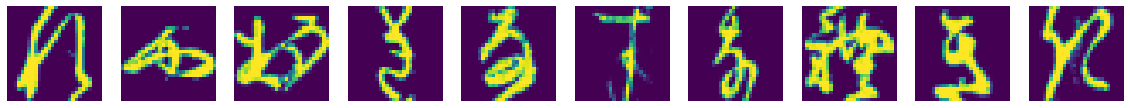

In [625]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(x_train[i]);
    ax[i].axis('off')

In [626]:
class kMNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super(kMNISTData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) 
    
    def __len__(self):
        return len(self.y) 
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]   
    
    

        

In [627]:
train_kmnist = kMNISTData(x_train, y_train) 
test_kmnist = kMNISTData(x_test, y_test) 
train_kmnist[0][0].shape

torch.Size([28, 28])

#### 3.2 Create encoder and decoder network for kMNIST. 
You can either use convolutions or flatten the images and use linear layers. You can choose hidden size (not larger than 40) and any architecture you like. 

In [628]:
def trainy(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    
    freq = max(epochs//20,1)
    net.to(device)
    
    for epoch in range(1, epochs+1):
        net.train()

        losses_train = []
        for X, _ in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X = X.unsqueeze(1)
            # >>> your solution here <<<
            X = X.to(device)
            out = net(X)
            loss = criterion(X,out)
            # >>> SOLUTION ENDS HERE
            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_train.append(loss.item())

        
        net.eval()
        for X, _ in val_loader:
            losses_val = []
            X = X.unsqueeze(1)
            X = X.to(device)
            out = net(X)
            loss_val = criterion(X, out)
            losses_val.append(loss_val.item())

        if scheduler is not None:
            scheduler.step()
        
        if verbose and epoch%freq==0:
            mean_val = sum(losses_val)/len(losses_val)
            mean_train = sum(losses_train)/len(losses_train)

            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'\
                  .format(epoch, epochs, mean_train, mean_val))

In [629]:
#Define the Convolutional Autoencoder
class encoder(torch.nn.Module):
    def __init__(self, dim):
        super(encoder, self).__init__()
        self.dim = dim
        self.drop_layer = nn.Dropout(p = 0.1)
        self.enc = nn.Sequential(
                        # >>> your solution here <<<
             #Encoder
        torch.nn.Conv2d(1, 24, 3, padding=1),
        torch.nn.BatchNorm2d(24),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2, 2),
        torch.nn.Conv2d(24, 16, 3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2, 2),
        torch.nn.BatchNorm2d(16),
        torch.nn.Conv2d(16, 8, 3, padding=1),  
        torch.nn.BatchNorm2d(8),
                        ) 
    
    
    def forward(self, x):
        return self.drop_layer(self.enc(x))
    
class decoder(torch.nn.Module):
    def __init__(self, dim):
        super(decoder, self).__init__()
        self.dim = dim
        self.drop_layer = nn.Dropout(p=0.1)
        self.dec =nn.Sequential(
                        # >>> your solution here <<<
            #Decoder
        torch.nn.ConvTranspose2d(8, 16, 3, padding=1),
        torch.nn.ReLU(),   
        torch.nn.BatchNorm2d(16),
        torch.nn.ConvTranspose2d(16, 24, 3, padding =1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(24),
        torch.nn.ConvTranspose2d(24, 1, 3, padding = 1, output_padding = 1, stride = 2),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(1, 1, 3, padding = 1, output_padding = 1, stride = 2),
        torch.nn.Sigmoid()
                        )  
        
    def forward(self, x):
        return self.drop_layer(self.dec(x))


       
       
       
        

In [630]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# >>> your solution here <<<

net = MyFirstAE(encoder(40), decoder(40)) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01) # >>> your solution here <<<
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(10, 20, 30, 60), gamma=1/2) # >>> your solution here <<<

train_loader = torch_data.DataLoader(train_kmnist, batch_size=128, shuffle=True) 
val_loader = torch_data.DataLoader(test_kmnist, batch_size=128, shuffle=False) 


In [631]:
epochs = 25
trainy(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler)

Epoch 1/25 || Loss:  Train 0.0501 | Validation 0.0196
Epoch 2/25 || Loss:  Train 0.0303 | Validation 0.0156
Epoch 3/25 || Loss:  Train 0.0291 | Validation 0.0149
Epoch 4/25 || Loss:  Train 0.0286 | Validation 0.0154
Epoch 5/25 || Loss:  Train 0.0284 | Validation 0.0167
Epoch 6/25 || Loss:  Train 0.0283 | Validation 0.0151
Epoch 7/25 || Loss:  Train 0.0282 | Validation 0.0148
Epoch 8/25 || Loss:  Train 0.0281 | Validation 0.0148
Epoch 9/25 || Loss:  Train 0.0282 | Validation 0.0142
Epoch 10/25 || Loss:  Train 0.0280 | Validation 0.0144
Epoch 11/25 || Loss:  Train 0.0279 | Validation 0.0153
Epoch 12/25 || Loss:  Train 0.0278 | Validation 0.0132
Epoch 13/25 || Loss:  Train 0.0279 | Validation 0.0138
Epoch 14/25 || Loss:  Train 0.0278 | Validation 0.0144
Epoch 15/25 || Loss:  Train 0.0278 | Validation 0.0140
Epoch 16/25 || Loss:  Train 0.0278 | Validation 0.0133
Epoch 17/25 || Loss:  Train 0.0278 | Validation 0.0135
Epoch 18/25 || Loss:  Train 0.0278 | Validation 0.0138
Epoch 19/25 || Loss

#### 3.3 Plot any 10 images and their reconstructions.

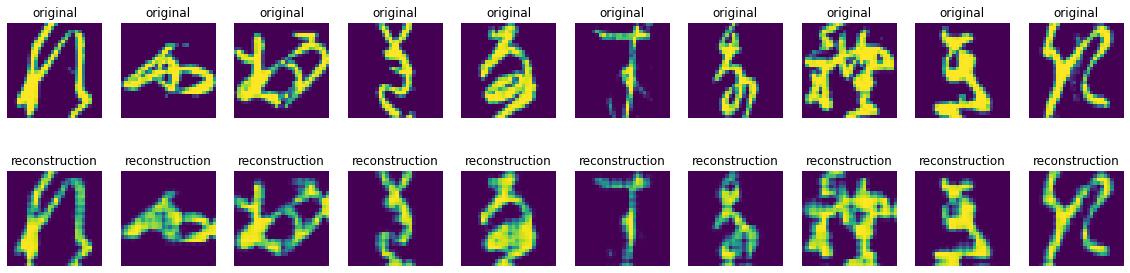

In [632]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
net.eval()
for i in range(10):
    im = train_kmnist[i][0]    
    
    im_tensor = torch.Tensor(im[None, :]).to(device).unsqueeze(1)
    rec = net(im_tensor).data.cpu().numpy()
        
    ax[0, i].imshow(im.reshape(28,28));
    ax[0, i].set_title('original')
    ax[1, i].imshow(rec.reshape(28,28));
    ax[1, i].set_title('reconstruction')
    ax[0, i].axis('off')
    ax[1, i].axis('off')

### Discuss results based on resutling plot. 
<br>
Describe your observations. How can we have produce better representaons? What will be if we take a mean vector of two latents and generate a new image from it, will it work? What will be if we use random noise instead of latent representations, will it work?
<br>
MY ANSWER:
<br>
I used a convolutional autoencoder with 3 convolution layers in encoder and decoder. We can add more convolutional layers together with data augumentaion to reach better representations.

Then, of course, we can take arbitrary vectors from latent space and decode them into initial space, getting weird pictures (you can see the result of decoding a random noise below).
<br>


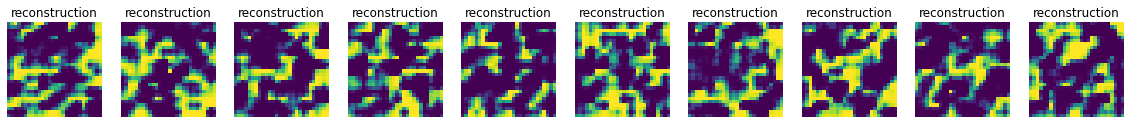

In [659]:



fig, axx = plt.subplots(ncols=10, nrows=1, figsize=(20, 5))
for i in range(10):
       
    
    im = torch.randn(1,8,7,7)
    rec = net.decoder(im).data.cpu().numpy()
  
    axx[ i].imshow(rec.reshape(28,28));
    axx[ i].set_title('reconstruction')
    
    axx[i].axis('off')